# loop through a series of fits files, fit gaussians, calculate aperture photometry

In [1]:
import glob
import numpy as np
import astropy.units as u
from astropy.coordinates import Angle
from astropy.io import fits
from astropy.modeling import models, fitting
%matplotlib inline

In [2]:
# create a gaussian beam in an image with size Npix x Npix (should be an odd number)
# beam size specified in pixels and PA in degrees counterclockwise from North
def gauss_beam(Npix, bmaj, bmin, PA, SNR=None):
    
    # make sure Npix is odd
    #if (Npix % 2) == 0:
    #    Npix -= 1
    #cen = int(Npix/2)

    beam = np.zeros((Npix, Npix))
    k = np.arange(Npix) - int(Npix/2)
    I, J = np.meshgrid(k, k)
    PAr = np.radians(90 - PA) 
    Irot = I * np.cos(PAr) - J * np.sin(PAr)
    Jrot = I * np.sin(PAr) + J * np.cos(PAr)
    Rsq = (Irot/bmaj)**2 + (Jrot/bmin)**2
    beam = np.exp(-Rsq)
    
    if SNR is not None:
        beam += np.random.normal(0, 1/SNR, size=beam.shape)

    return beam/beam.sum()

In [3]:
def findpeak(im, hd, R0=None):
    x = (1+np.arange(hd['NAXIS1']) - hd['CRPIX1']) * hd['CDELT1'] * 3600
    y = (1+np.arange(hd['NAXIS2']) - hd['CRPIX2']) * hd['CDELT2'] * 3600
    
    if R0 is None:
        R0 = 10

    innerdisk = R < R0
    peak = np.max(im[innerdisk])
    im[~innerdisk] = -1
    k = np.argmax(im)
    j, i = np.unravel_index(np.argmax(im), im.shape)
    xpeak = x[i]
    ypeak = y[j]
    
    return peak, xpeak, ypeak

In [4]:
# fit a gaussian to the image within radius R (arcseconds) of the center
def gaussfit(im, hd, R0=None, plot=False):
    x = (1+np.arange(hd['NAXIS1']) - hd['CRPIX1']) * hd['CDELT1'] * 3600
    y = (1+np.arange(hd['NAXIS2']) - hd['CRPIX2']) * hd['CDELT2'] * 3600
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    innerdisk = R < R0
    p_init = models.Gaussian2D(amplitude=np.max(im[innerdisk]), x_mean=0, y_mean=0)
    fit_p = fitting.LevMarLSQFitter()
    p = fit_p(p_init, X[innerdisk], Y[innerdisk], im[innerdisk])

    A = p.amplitude.value
    center = (p.x_mean.value, p.y_mean.value)
    x_fwhm = p.x_stddev.value
    y_fwhm = p.y_stddev.value
    PA = 90 - p.theta.value * 180/np.pi
    abs_center = (hd['CRVAL1']+center[0]/3600, hd['CRVAL2']+center[1]/3600)
    
    # make x_fwhm the major axis and keep PA between -90 and 90 degrees
    if (y_fwhm > x_fwhm):
        x_fwhm, y_fwhm = y_fwhm, x_fwhm
        PA -= 90
    PA = PA % 180
    if (PA > 90):
        PA -= 180
    size = (x_fwhm, y_fwhm, PA)
    
    # calculate peak and noise in the residuals
    xm, ym = np.meshgrid(x, y)
    img = p(xm, ym)
    res = im - img
    res_peak = np.max(res[innerdisk])
    res_rms = np.std(res[innerdisk])

    if plot:
        vmax = np.max(im[innerdisk])
        vmin = -0.1*vmax
        fig = plt.figure(figsize=(8,20))
        ax1 = fig.add_subplot(131)
        ax1.imshow(im, vmin=vmin, vmax=vmax, extent=[np.max(x), np.min(x), np.min(y), np.max(y)], origin='lower')
        ax2 = fig.add_subplot(132)
        ax2.imshow(img, vmin=vmin, vmax=vmax, extent=[np.max(x), np.min(x), np.min(y), np.max(y)], origin='lower')
        ax3 = fig.add_subplot(133)
        ax3.imshow(10*res, vmin=vmin, vmax=vmax, extent=[np.max(x), np.min(x), np.min(y), np.max(y)], origin='lower')
        for ax in [ax1, ax2, ax3]:
            ax.set_xlim( 1,-1)
            ax.set_ylim(-1, 1)
        ax2.set_title(hd['OBJECT'])
            
    return A, center, abs_center, size, res_peak, res_rms

In [5]:
# measure the mean (= flux offset) and standard deviation (=rms) of the image in an input annulus region
# annulus is 2 element tuple or array in arcseconds
# output is in image units (Jy/beam)
def get_noise(im, hd, annulus):
    x = (np.arange(hd['NAXIS1']) - hd['CRPIX1'] -1) * hd['CDELT1'] * 3600
    y = (np.arange(hd['NAXIS2']) - hd['CRPIX2'] -1) * hd['CDELT2'] * 3600
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    annulus_flag = (R > annulus[0]) & (R < annulus[1])
    offset = np.mean(im[annulus_flag])
    rms = np.std(im[annulus_flag])
    
    return offset, rms

In [6]:
# measure the flux of the central source through a curve of growth analysis
def curve_of_growth(im, hd, radii, center=None, rms=None, plot=False):
    x = (1+np.arange(hd['NAXIS1']) - hd['CRPIX1']) * hd['CDELT1'] * 3600
    y = (1+np.arange(hd['NAXIS2']) - hd['CRPIX2']) * hd['CDELT2'] * 3600
    if center is not None:
        x -= center[0]
        y -= center[1]
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2)
    
    Apix = np.abs(hd['CDELT1'] * hd['CDELT2']) * 3600**2
    Abeam = np.pi * hd['BMAJ'] * hd['BMIN'] * 3600**2 / (4 * np.log(2))
    
    if plot:
        fig = plt.figure(figsize=(6,6))
        
        phi = np.arange(41)*np.pi/20
        ct = np.cos(phi)
        st = np.sin(phi)

        plt.imshow(im, extent=[np.max(x), np.min(x), np.min(y), np.max(y)], origin='lower')
        #plt.plot(xpeak, ypeak, '+', color='k', mew=5)
        #plt.imshow(im0, extent=[np.max(x-xpeak), np.min(x-xpeak), np.min(y-ypeak), np.max(y-ypeak)], origin='lower')
        plt.plot(0, 0, '+', color='k', ms=15)
        plt.xlim( 1.5*np.max(radii), -1.6*np.max(radii))
        plt.ylim(-1.5*np.max(radii),  1.5*np.max(radii))
    
    print('Curve of Growth:')
    if rms is None:
        print('-------------------------')
        print('Radius   #Beams    Flux  ')
        print('-------------------------')
    else:
        print('--------------------------------')
        print('Radius   #Beams    Flux    SNR  ')
        print('--------------------------------')
    nr = radii.size
    for k, r in enumerate(radii):
        aper = R < r
        npix = aper.sum()
        nbeam = npix * Apix / Abeam
        signal = np.sum(im[aper])      # mJy/beam summed over npix pixels
        flux = signal * Apix / Abeam   # mJy
        if rms is None:
            print(f'{r:4.2f}    {nbeam:6.2f}   {flux:6.2f}')
        else:
            snr = signal / (np.sqrt(npix)*rms)
            print(f'{r:4.2f}    {nbeam:6.2f}   {flux:6.2f}   {snr:5.1f}')
        if plot:
            plt.plot(r*ct, r*st, ':')
    if rms is None:
        print('-------------------------')    
    else:
        print('--------------------------------')

    return flux, snr, r

In [7]:
def readfits(filename, mJy=True):
    hdulist = fits.open(f)
    hd = hdulist[0].header
    im  = hdulist[0].data.squeeze()
    if mJy:
        im *= 1000
        
    return im, hd

In [8]:
def do_photometry(f):
    print(f"filename = {f}")
    im, hd = readfits(f)
    print(f"Beam size = {3600*hd['BMAJ']:6.3f} arcsec x {3600*hd['BMIN']:6.3f} arcsec at PA {hd['BPA']:4.1f} degrees CCW from N")
    
    # test
    #im = gauss_beam(im.shape[0], 20, 5, 70) * 1000
    
    A, cen, abscen, size, peak_res, rms_res = gaussfit(im, hd, R0=5, plot=True)
    print('Gaussfit results:')
    print(f'     Amplitude = {A:6.3f} mJy/beam')
    print(f'     Center Dx, Dy = {cen[0]:6.3f}, {cen[1]:6.3f} arcsec')
    print(f'     FWHM size = {size[0]:6.3f} arcsec x {size[1]:6.3f} arcsec at PA {size[2]:4.1f} degrees CCW from N')
    print(f'     Residual peak, rms = {peak_res:5.2f}, {rms_res:5.2f} mJy/beam')
    
    noise_annulus = [5, 10]
    offset, rms = get_noise(im, hd, noise_annulus)
    print(f'Mean level in annulus = {offset:5.2f} mJy/beam')
    print(f'rms in annulus = {rms:5.2f} mJy/beam')
    
    if A > 3*rms:
        print('')
        radii = (1+np.arange(5))*0.2
        flux, snr, r = curve_of_growth(im, hd, radii, center=cen, rms=rms, plot=False)
    else:
        print('Not detected')
        flux, snr, r = 0, 0, 0
        
    offset_threshold = 0.03
    if offset > offset_threshold:
        print('Large offset in noise annulus: check data')
    print('')
        
    d = {f.strip('.fits'):{'gaussfit':{'peak':A, 'center':abscen, 'size':size, 'rms':rms}, 'aperture_photometry':{'flux':flux, 'snr':snr, 'radius':r}}}
    return d

filename = HD37411.fits
Beam size =  0.459 arcsec x  0.347 arcsec at PA -78.2 degrees CCW from N
Gaussfit results:
     Amplitude = 14.102 mJy/beam
     Center Dx, Dy =  0.022,  0.006 arcsec
     FWHM size =  0.201 arcsec x  0.152 arcsec at PA -78.8 degrees CCW from N
     Residual peak, rms =  0.25,  0.07 mJy/beam
Mean level in annulus =  0.00 mJy/beam
rms in annulus =  0.09 mJy/beam

Curve of Growth:
--------------------------------
Radius   #Beams    Flux    SNR  
--------------------------------
0.20      0.69     7.12   589.8
0.40      2.78    13.70   564.6
0.60      6.31    14.85   406.5
0.80     11.14    15.02   309.6
1.00     17.34    15.13   249.9
--------------------------------



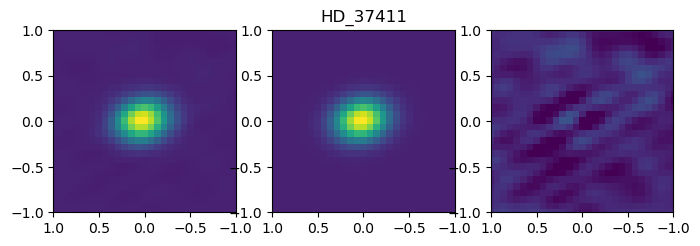

In [9]:
fitslist = glob.glob('*.fits')
dict_all = {}
for f in fitslist:
    d = do_photometry(f)
    dict_all = {**dict_all, **d}

In [10]:
# order the dictionary by RA
sources = list(dict_all.keys())
ra_deg = np.zeros(len(sources))
for i,s in enumerate(sources):
    ra_deg[i] = (dict_all[s]['gaussfit']['center'][0])

dict_sorted = {}
for i in np.argsort(ra_deg):
    s1 = sources[i]
    d1 = dict_all[s1]
    dict_sorted = {**dict_sorted, **{s1: d1}}

In [11]:
# write out results to a text file
f = open('photometry.txt', 'w')
f.write('# Source                          RA           Dec          Flux    rms   \n')
f.write('#                                 hms          dms          mJy    mJy/bm \n')
f.write('#-------------------------------------------------------------------------\n')

sources = dict_sorted.keys()
for s in sources:
    ra  = Angle(dict_sorted[s]['gaussfit']['center'][0]*u.deg).hms
    dec = Angle(dict_sorted[s]['gaussfit']['center'][1]*u.deg).dms
    flux = dict_sorted[s]['aperture_photometry']['flux']
    rms = dict_sorted[s]['gaussfit']['rms']
    f.write(f'{s:30s} {ra[0]:02g}:{ra[1]:02g}:{ra[2]:05.2f}  {dec[0]:03g}:{abs(dec[1]):02g}:{abs(dec[2]):05.2f}   {flux:5.2f}   {rms:5.3f}\n')

f.close()